<a href="https://colab.research.google.com/github/Wallyff/Atividade-2-segunda-unidade/blob/main/C%C3%B3pia_de_An%C3%A1lise_2_Trade_Quantitativo_Escolhendo_a_Estrat%C3%A9gia_%C3%93tima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Rodar no colab para instalar pacotes necessários {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
# Run This Cell for Colab
# Just instaling the required packages

!pip install yfinance
!pip install vectorbt
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 526 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 526 kB 7.8 MB/s 
     |████████████████████████████████| 292 kB 39.7 MB/s 
     |████████████████████████████████| 1.6 MB 44.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 237 kB/s 


In [ ]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Definindo parâmetros

In [ ]:
# Análise de um Ativo Americano
codigo = 'AAPL'
ativos_comparacao = [codigo, '^GSPC', 'AMZN', 'NFLX']

data_inicial = '2017-01-01'  
data_final = '2018-01-01'

# Os preços de fechamentos dos ativos
vbt.YFData.download(ativos_comparacao, start=data_inicial, end=data_final).get('Close')

symbol,AAPL,^GSPC,AMZN,NFLX
Date,,,,
2017-01-03 05:00:00+00:00,27.174759,2257.830078,37.683498,127.489998
2017-01-04 05:00:00+00:00,27.144341,2270.750000,37.859001,129.410004
2017-01-05 05:00:00+00:00,27.282381,2269.000000,39.022499,131.809998
2017-01-06 05:00:00+00:00,27.586529,2276.979980,39.799500,131.070007
2017-01-09 05:00:00+00:00,27.839205,2268.899902,39.846001,130.949997
...,...,...,...,...
2017-12-22 05:00:00+00:00,41.604237,2683.340088,58.417999,189.940002
2017-12-26 05:00:00+00:00,40.548740,2680.500000,58.838001,187.759995
2017-12-27 05:00:00+00:00,40.555882,2682.620117,59.112999,186.240005


## Baixando os dados

In [ ]:
precos = vbt.YFData.download(codigo, start=data_inicial, end=data_final).get()
fechamento = vbt.YFData.download(codigo, start=data_inicial, end=data_final).get('Close')

# Parte I - Analisando a Série

In [ ]:
fechamento.vbt.plot().show()

In [ ]:
precos.vbt.ohlcv.plot().show()

## Gráfico comparativo

Com investimento inicial de \$1 (ou R\$ 1)

In [ ]:
vbt.YFData.download(ativos_comparacao,
                    start=data_inicial,
                    end=data_final).plot(column='Close', base=1).show()

## Gráfico Quant Stat

Retorno Cumulativo, Drawdown e Retorno Diário

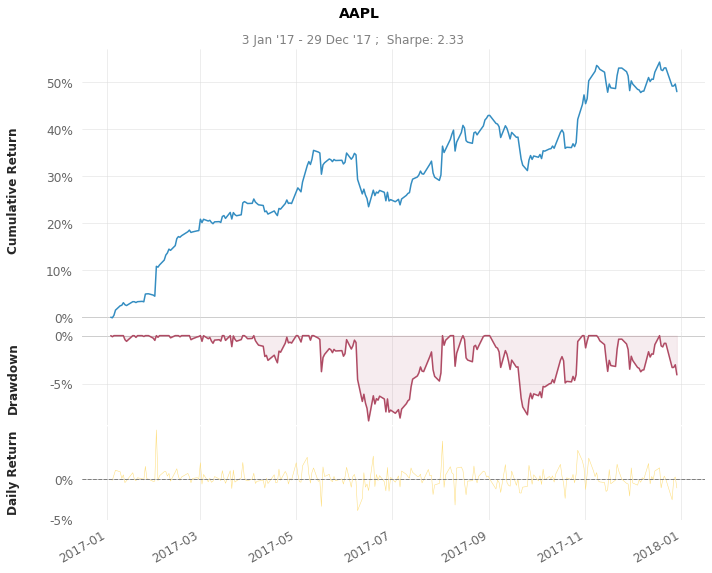

In [ ]:
warnings.filterwarnings('ignore')

retornos = fechamento.vbt.to_returns()
retornos.vbt.returns.qs.plot_snapshot(title=codigo)

# Analisando Estratégias de Trade

## Média Móvel Simples (SMA)

SMA: Simple Moving Averages

In [ ]:
n_periodos_curta = 20
n_periodos_longa = 50

media_curta = vbt.MA.run(fechamento, n_periodos_curta, short_name='media_curta')
media_longa = vbt.MA.run(fechamento, n_periodos_longa, short_name='media_longa')

fig = fechamento.vbt.plot(trace_kwargs=dict(name='Preço de Fechamento'))
media_curta.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Curta'), fig=fig)
media_longa.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Longa'), fig=fig)

fig.show()

## Índice de Força Relativa (RSI)

RSI: Relative Strength Index

In [ ]:
rsi = vbt.RSI.run(fechamento)
rsi.plot().show()

## Estocástico (Stochastics)

In [ ]:
vbt.STOCH.run(precos['High'], precos['Low'], precos['Close']).plot().show()

## Bandas de Bolinger (Bollinger Bands)

In [ ]:
vbt.BBANDS.run(fechamento).plot().show()

# Parte II - Escolhendo Melhor Estratégia

## Testando manualmente

### Teste dentro da amostra (in-sample)

In [ ]:
estrategia_media_movel_curta = 10
estrategia_media_movel_longa = 30

media_movel_curta = vbt.MA.run(fechamento, estrategia_media_movel_curta, short_name='fast_ma')
media_movel_longa = vbt.MA.run(fechamento, estrategia_media_movel_longa, short_name='slow_ma')

entradas = media_movel_curta.ma_crossed_above(media_movel_longa)
saidas = media_movel_curta.ma_crossed_below(media_movel_longa)

# Create the Signals Portfolio
pf = vbt.Portfolio.from_signals(fechamento,
                                entries=entradas,
                                exits=saidas,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

print("Retorno Total (%):", round(pf.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf.sharpe_ratio(),2)) # Entenda IS em https://pt.wikipedia.org/wiki/%C3%8Dndice_de_Sharpe

Retorno Total (%): 7.8
Retorno Anualizado (%): 11.54
Índice Sharpe: 0.74


In [ ]:
# print(pf.stats()) # Todas as estatisticas do Portfolio

In [ ]:
# print(pf.returns_stats()) # Todas as estatisticas do retorno

In [ ]:
# Gráfico da Estratégia
fig = pf.close.vbt.plot(trace_kwargs=dict(name='Preço de Fechamento'))
media_movel_curta.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Curta'), fig=fig)
media_movel_longa.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Longa'), fig=fig)
pf.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()

In [ ]:
# Mostrar as ordens
# pf.orders.records_readable

In [ ]:
# Gráfico de Saldo em Caixa e valor dos Ativos investidos
# pf.plot(subplots=['cash', 'assets', 'value']).show()

### Analisar Fora da Amostra (out-of-sample)

In [ ]:
# Baixar dados fora da amostra
data_inicial2 = data_final 
data_final2 = '2019-01-01'
precos2 = vbt.YFData.download(codigo, start=data_inicial2, end=data_final2).get()
fechamento2 = vbt.YFData.download(codigo, start=data_inicial2, end=data_final2).get('Close')
print(precos2)

                                Open       High        Low      Close  \
Date                                                                    
2018-01-02 05:00:00+00:00  40.451280  40.960012  40.237326  40.950500   
2018-01-03 05:00:00+00:00  41.014681  41.494887  40.879180  40.943363   
2018-01-04 05:00:00+00:00  41.017062  41.238148  40.907711  41.133549   
2018-01-05 05:00:00+00:00  41.231014  41.689821  41.138301  41.601864   
2018-01-08 05:00:00+00:00  41.447346  41.746878  41.347498  41.447346   
...                              ...        ...        ...        ...   
2018-12-24 05:00:00+00:00  35.747698  36.568099  35.371280  35.429192   
2018-12-26 05:00:00+00:00  35.783888  37.938641  35.402643  37.924164   
2018-12-27 05:00:00+00:00  37.603247  37.827652  36.210983  37.678047   
2018-12-28 05:00:00+00:00  38.003802  38.249922  37.291985  37.697357   
2018-12-31 05:00:00+00:00  38.252319  38.452594  37.757666  38.061699   

                              Volume  Dividends  S

In [ ]:
# Testar estratégia fora da amostra
media_movel_curta2 = vbt.MA.run(fechamento2, estrategia_media_movel_curta, short_name='fast_ma')
media_movel_longa2 = vbt.MA.run(fechamento2, estrategia_media_movel_longa, short_name='slow_ma')

entradas2 = media_movel_curta2.ma_crossed_above(media_movel_longa2)
saidas2 = media_movel_curta2.ma_crossed_below(media_movel_longa2)

# Create the Signals Portfolio
pf2 = vbt.Portfolio.from_signals(fechamento2,
                                entries=entradas2,
                                exits=saidas2,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

In [ ]:
# Comparar desempenho
print("=" * 70,"\n")
print("RESULTADO NA AMOSTRA DE TESTE (in-sample)\n")
print("Retorno Total (%):", round(pf.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf.sharpe_ratio(),2))
print("=" * 70,"\n")
print("RESULTADO FORA DA AMOSTRA (out-of-sample)\n")
print("Retorno Total (%):", round(pf2.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf2.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf2.sharpe_ratio(),2))
print("=" * 70)


RESULTADO NA AMOSTRA DE TESTE (in-sample)

Retorno Total (%): 7.8
Retorno Anualizado (%): 11.54
Índice Sharpe: 0.74

RESULTADO FORA DA AMOSTRA (out-of-sample)

Retorno Total (%): -5.46
Retorno Anualizado (%): -7.84
Índice Sharpe: -0.32


### Comentário
**Análise dos dados:**
*A partir da análise dos resultados gerados e expressos, é facilmente visível a variação e diferenças entre os valores resultantes, onde os valores relacionados a amostra de teste (in-sample) apresentam resultados com valores positivos no retorno total (7.8%) que é utilizado para medir a taxa real de retorno de um investimento durante um terminado período de tempo, no retorno anualizado (11.54%) que consiste no retorno anual equivalente a que um investidor tem direito e no índice sharpe (0.74%) que é utilizado para realizar avaliações de fundos de investimentos, no qual expressa a relação risco x retorno. Já no Resultado fora da amostra (out-of-sample) todos os valores resultantes foram todos negativos, no retorno total (-5.46%), no retorno anualizado (-7.84%) e no índice sharpe (-0.32%), obtendo um resultado de queda brusca em comparação aos valores referentes dentro da amostra na qual dentro da amostra seria viável investir, entretanto fora da amostra seria inviável investir por não obter retornos.*

## Otimizando computacionalmente

### Escolher janela de teste

In [ ]:
# Definir intervalo de janelas
janelas = np.arange(10, 50)
print(janelas)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


In [ ]:
fechamento

Date
2017-01-03 05:00:00+00:00    27.174755
2017-01-04 05:00:00+00:00    27.144335
2017-01-05 05:00:00+00:00    27.282377
2017-01-06 05:00:00+00:00    27.586531
2017-01-09 05:00:00+00:00    27.839207
                               ...    
2017-12-22 05:00:00+00:00    41.604240
2017-12-26 05:00:00+00:00    40.548744
2017-12-27 05:00:00+00:00    40.555874
2017-12-28 05:00:00+00:00    40.669983
2017-12-29 05:00:00+00:00    40.230179
Name: Close, Length: 251, dtype: float64

In [ ]:
# Testar automaticamente diversas combinações de janelas
# fast_ma, slow_ma = vbt.MA.run_combs(price, windows)
media_movel_curta3, media_movel_longa3 = vbt.MA.run_combs(fechamento, janelas)

# entries = fast_ma.ma_crossed_above(slow_ma)
# exits = fast_ma.ma_crossed_below(slow_ma)
entradas3 = media_movel_curta3.ma_crossed_above(media_movel_longa3)
saidas3 = media_movel_curta3.ma_crossed_below(media_movel_longa3)

# portfolio = vbt.Portfolio.from_signals(price, entries, exits, freq='1d', direction='both')
# Create the Signals Portfolio
pf3 = vbt.Portfolio.from_signals(fechamento,
                                entries=entradas3,
                                exits=saidas3,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

### Resultado in-sample

In [ ]:
# print("Retorno Total (%):\n\n", round(pf3.total_return().sort_values() * 100,2))
# print("Retorno Anualizado (%):\n\n", round(pf3.annualized_return().sort_values() * 100,2))
print("Índice Sharpe:\n\n", round(pf3.sharpe_ratio().sort_values(),2))

Índice Sharpe:

 ma_1_window  ma_2_window
46           48            -1.59
41           42            -1.48
             43            -1.48
46           47            -1.43
43           44            -1.37
                            ... 
16           21             1.07
17           21             1.09
16           23             1.17
17           22             1.22
16           22             1.32
Name: sharpe_ratio, Length: 780, dtype: float64


### Testar fora da amostra (out-of-sample)

Testando a melhor estratégia encontrada na etapa anterior (atulizar números com as melhores janelas).

### A FAZER: Colocar manualmente a melhor estrategia

In [ ]:
estrategia_otima_media_movel_curta = 16
estrategia_otima_media_movel_longa = 22

In [ ]:
# Rodar teste
media_movel_curta4 = vbt.MA.run(fechamento2, estrategia_otima_media_movel_curta, short_name='fast_ma')
media_movel_longa4 = vbt.MA.run(fechamento2, estrategia_otima_media_movel_longa, short_name='slow_ma')

entradas4 = media_movel_curta4.ma_crossed_above(media_movel_longa4)
saidas4 = media_movel_curta4.ma_crossed_below(media_movel_longa4)

# Create the Signals Portfolio
pf4 = vbt.Portfolio.from_signals(fechamento2,
                                entries=entradas4,
                                exits=saidas4,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

### Analisar Resultados (out-of-sample)

In [ ]:
# Comparar desempenho
print("=" * 70,"\n")
print("RESULTADO NA AMOSTRA DE TESTE (in-sample)\n")
# print("Retorno Total (%):", round(float(pf3.total_return().sort_values().tail(1).values) * 100,2))
# print("Retorno Anualizado (%):", round(float(pf3.annualized_return().sort_values().tail(1).values) * 100,2))
print("Índice Sharpe:", round(float(pf3.sharpe_ratio().sort_values().tail(1).values),2))
print("=" * 70,"\n")
print("RESULTADO FORA DA AMOSTRA (out-of-sample)\n")
# print("Retorno Total (%):", round(pf4.total_return() * 100,2))
# print("Retorno Anualizado (%):", round(pf4.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf4.sharpe_ratio(),2))
print("=" * 70)


RESULTADO NA AMOSTRA DE TESTE (in-sample)

Índice Sharpe: 1.32

RESULTADO FORA DA AMOSTRA (out-of-sample)

Índice Sharpe: -0.17


### COMENTÁRIO: 
**Análise dos dados:**
*Não funcionou, pois o índice de sharpe igual ou superior a 1 implica que esse é um ótimo fundo, um índice de (0,5) é um bom fundo e (1.0) índice for igual ou menor que (0.0) implica que o fundo não entrega resultados acima do ativo de livre risco, sendo assim uma má escolha para se investir. Sendo assim, o resultado do índice de dentro da amostra apresentou um ótimo fundo de (1.32) tendo assim um retorno significativo para o investidor, diferentemente do índice fora da amostra que foi de (-0.17) que implica em um investimento bastante ruim. A diferença pode ser resultante de analisar um dado período anterior para estipular um valor futuro, podendo assim existir erros visto que podem existir fatores externos que podem implicar tanto positivamente, quanto negativamente no valor.*

(Funcinou? Não funcinou? Porque deu diferente?)

# Próximo tópico:

Treino, validação e teste.

<img src="https://vectorbt.dev/assets/images/features_rolling_split.svg">
